## 1-vs-(N-1) Flu ABM Env
- 1-vs-(N-1) experiment
- Basic AC learner
- For comparison with MARL outcomes

In [1]:
import itertools, importlib, sys, warnings, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML libs
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
print("Pandas version:", pd.__version__)

log_path = './log/flu'
#tensorboard --logdir=flugame_worker_1:'./log/<<..>>'

## suppress annoy verbose tf msgs
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # '3' to block all including error msgs
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# plt.rcParams['figure.figsize'] = (18,7)

Tensorflow version: 1.15.0
Pandas version: 0.25.3


In [2]:
sys.path.append('./embodied_arch')

import embodied_AC as emg
import flumodel_python.flu_env as Fenv
from embodied_misc import ActionPolicyNetwork, ValueNetwork, SensoriumNetworkTemplate

importlib.reload(emg)

<module 'embodied_AC' from './embodied_arch/embodied_AC.py'>

## Env Setup - Single Agent

In [3]:
importlib.reload(Fenv);
# ?Fenv.Flu_env

In [4]:
exos = np.random.choice(9223)
exos

5423

In [5]:
tf.reset_default_graph()
flu_env = Fenv.Flu_env(
    exo_idx=exos,
    model_path="./flumodel_python/"
)

### SARL Setup Demo

In [6]:
actor = lambda s: ActionPolicyNetwork(s, hSeq=(8,), gamma_reg=1e-1)
value = lambda s: ValueNetwork(s, hSeq=(8,), gamma_reg=1.)
sensor = lambda st, out_dim: SensoriumNetworkTemplate(st, hSeq=(16,8,8), out_dim=out_dim, gamma_reg=5.)

num_episodes, max_len, n_epochs, evry = (100, 35, 751, 150)
# num_episodes, n_epochs, max_len = (30, 400, 25)

In [7]:
importlib.reload(emg);

flurf = emg.EmbodiedAgentAC(
    name="fluAC", env_=flu_env, 
    _every_=evry, max_episode_length=max_len, 
    latentDim=4, alpha_p=10., alpha_v=5., 
    actorNN=actor, sensorium=sensor, valueNN=value
)

print(flurf, flurf.s_size, flurf.a_size)

<embodied_AC.EmbodiedAgentAC object at 0x7fb9b0ff3110> 8 1


In [8]:
print(flu_env.state_space_size, flu_env.action_space_size)

8 1


### Burn-in Flu ABM to Equilibrium

0.07598395316057682 0.05665959325289261


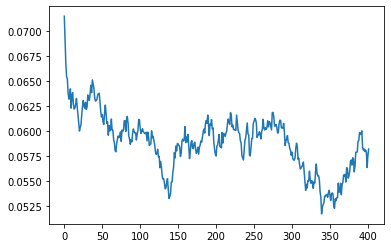

In [9]:
burn_in = 451
flurf.env.soft_reset(DBM_reset=True)
flurf.env.infection_rate_history
for _ in range(burn_in):
    _ = flurf.env.stepAll()


plt.plot(pd.Series(flurf.env.infection_rate_history).rolling(window=50).mean().iloc[50-1:].values);

print(
    np.mean(np.array(flurf.env.infection_rate_history)[:flurf.max_episode_length]),
    np.mean(np.array(flurf.env.infection_rate_history)[-flurf.max_episode_length:])
)

## no equilibrium, just cycling...

## Baseline

In [10]:
sess = tf.InteractiveSession()
flurf.init_graph(sess) # note tboard log dir

Tensorboard logs in:  ./log/train_fluAC


In [11]:
print('Baselining untrained pnet...')
rwds0 = []
for k in range(num_episodes):
    flurf.play(sess, terminal_reward=0.);
    rwds0.append(flurf.last_total_return)
    print("\rEpisode {}/{}".format(k, num_episodes),end="")

# Compute average rewards
base_perf = 100.*np.mean(np.array(rwds0)/float(flurf.max_episode_length))

print("\nAgent is flu-free for an average of {}pct of seasons".format(1.*base_perf))

Baselining untrained pnet...
Episode 99/100
Agent is flu-free for an average of 94.71428571428572pct of seasons


## Train

	Iteration 39: Value loss(2.978991746902466)))

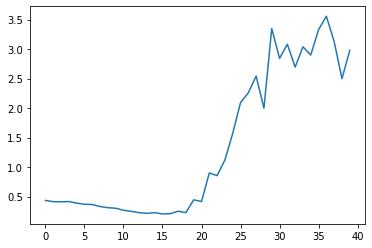

In [12]:
obs = []
for ct in range(40):
    flurf.play(sess)
    tmp = flurf.pretrainV(sess)
    obs.append(tmp)
    print('\r\tIteration {}: Value loss({})'.format(ct, tmp), end="")
plt.plot(obs)

In [13]:
# Train pnet on cartpole episodes
print('Training...')
saver = tf.train.Saver(max_to_keep=1)
hist = flurf.work(sess, saver, num_epochs=n_epochs);

Training...
Starting agent fluAC
Epoch no.: 0/751
Step 0: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Value Fxn', 'Losses/Entropy']): ( [32.0, -0.0895846, 2.6754167, 0.6882952] )
Saved Model
Epoch no.: 150/751
Step 150: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Value Fxn', 'Losses/Entropy']): ( [32.0, -0.027927427, 2.6384542, 0.6841873] )
Saved Model
Epoch no.: 300/751
Step 300: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Value Fxn', 'Losses/Entropy']): ( [32.0, 0.13610244, 2.412248, 0.6725986] )
Saved Model
Epoch no.: 450/751
Step 450: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Value Fxn', 'Losses/Entropy']): ( [33.0, -0.033349868, 1.9708086, 0.68544424] )
Saved Model
Epoch no.: 600/751
Step 600: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Value Fxn', 'Losses/Entropy']): ( [35.0, 0.134849, 2.1508675, 0.6482908] )
Saved Model
Epoch no.: 750/751
Step 750: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Value Fx

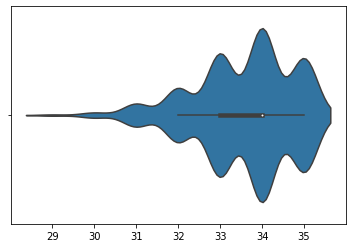

In [14]:
sns.violinplot(hist)

## Test

In [15]:
print('Testing...')
rwds = []
for k in range(num_episodes):
    flurf.play(sess, terminal_reward=0.);
    rwds.append(flurf.last_total_return)
    print("\rEpisode {}/{}".format(k, num_episodes),end="")

# Compute average rewards
trained_perf = 100.*np.mean(np.array(rwds)/float(flurf.max_episode_length))
print("\nAgent is flu-free for an average of {}pct of seasons compared to baseline {}pct".format(
    trained_perf, base_perf) )


Testing...
Episode 99/100
Agent is flu-free for an average of 97.08571428571429pct of seasons compared to baseline 94.71428571428572pct


## Evaluate

Text(0.5, 1.0, 'Trained Episode Rewards')

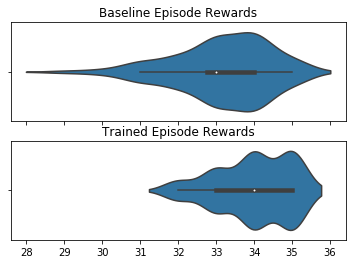

In [16]:
fig, axs = plt.subplots(2, 1, sharex=True)
sns.violinplot(rwds0, ax = axs[0])
axs[0].set_title('Baseline Episode Rewards')
sns.violinplot(rwds, ax = axs[1])
axs[1].set_title('Trained Episode Rewards')

In [21]:
100.*(np.array(rwds)-np.array(rwds0))/float(flurf.max_episode_length)

array([ 2.85714286, -2.85714286, 11.42857143,  0.        ,  5.71428571,
        0.        ,  0.        ,  2.85714286,  5.71428571,  2.85714286,
        2.85714286, 14.28571429,  5.71428571,  8.57142857,  2.85714286,
        0.        ,  5.71428571,  2.85714286, 11.42857143,  0.        ,
        8.57142857,  5.71428571,  2.85714286,  0.        ,  2.85714286,
        2.85714286,  2.85714286,  0.        , -5.71428571,  5.71428571,
       -2.85714286,  2.85714286, -2.85714286,  2.85714286,  8.57142857,
       -2.85714286,  5.71428571,  2.85714286,  8.57142857,  5.71428571,
        5.71428571, 11.42857143, -8.57142857,  8.57142857,  2.85714286,
        2.85714286,  2.85714286,  0.        ,  2.85714286,  0.        ,
       -5.71428571,  0.        ,  0.        ,  2.85714286,  2.85714286,
       -5.71428571,  5.71428571,  5.71428571,  0.        ,  2.85714286,
       11.42857143,  2.85714286, -2.85714286,  2.85714286,  2.85714286,
        2.85714286,  2.85714286,  0.        , -2.85714286,  0.  

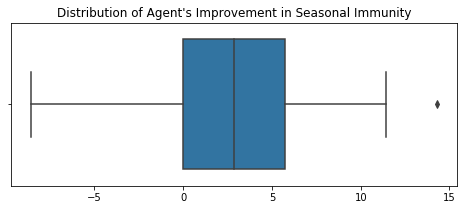

In [49]:
cmp = sns.boxplot(100.*(np.array(rwds)-np.array(rwds0))/float(flurf.max_episode_length))
cmp.set_title('Distribution of Agent\'s Improvement in Seasonal Immunity');

### Baseline for Default Behavioral Model
Using internal Env instead of new Flu Env

In [ ]:
# import flumodel_python.flu_env_basic as FABM
# # ?Fenv.Flu_ABM
# importlib.reload(FABM);
# flu = FABM.Flu_ABM(model_path="./flumodel_python/")

In [24]:
# No Burn-in Flu ABM... No DBM reset.
# note change in comparison standard: against average background popn, not against itself under DBM
flu_hist = np.zeros(num_episodes)
for k in range(num_episodes):
    for _ in range(flurf.max_episode_length):
        _ = flurf.env.stepAll() 
    flu_hist[k] = np.mean(np.array(flurf.env.infection_rate_history)[-flurf.max_episode_length:])

### Evaluate RL Agent Against Default Behavioral Model

In [71]:
rwds_dbm = 100.*(1.-flu_hist)
rwds_init = 100.*np.array(rwds0)/float(flurf.max_episode_length)
rwds_rl = 100.*np.array(rwds)/float(flurf.max_episode_length)
# print(rwds_dbm.shape, rwds_rl.shape)
print(np.mean(rwds_dbm), np.mean(rwds_init), np.mean(rwds_rl))
# print(np.mean(rwds_rl - rwds_dbm))

# plt.rcParams['figure.figsize'] = (8,3)
# cmp_dbm = sns.boxplot(rwds_rl-rwds_dbm)
# cmp_dbm.set_title(
#     'Average Difference in Agent Performance (Seasonal Non-Infection Pct):\nRL Agent over Default Behavioral Model ({:0.2f} pct)'.format(
#     np.mean(rwds_rl - rwds_dbm)));

93.98180325583557 94.71428571428571 97.08571428571426


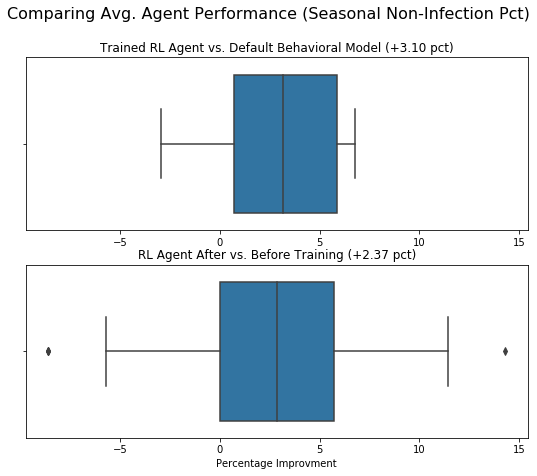

In [72]:
plt.rcParams['figure.figsize'] = (9,7)
fig, axs = plt.subplots(2, 1, sharex=True)

fig.suptitle("Comparing Avg. Agent Performance (Seasonal Non-Infection Pct)", fontsize=16)

sns.boxplot(rwds_rl-rwds_dbm, ax = axs[0])
axs[0].set_title('Trained RL Agent vs. Default Behavioral Model (+{:0.2f} pct)'.format(
    np.mean(rwds_rl - rwds_dbm)));
# axs[0].set_xlabel("Percentage Improvment");
axs[0].tick_params(labelbottom=True)
# plt.setp(axs[0].get_xticklabels(), visible=True)

sns.boxplot(rwds_rl-rwds_init, ax = axs[1])
axs[1].set_title('RL Agent After vs. Before Training (+{:0.2f} pct)'.format(
    np.mean(rwds_rl - rwds_init)));
axs[1].set_xlabel("Percentage Improvment");